<a href="https://colab.research.google.com/github/AndreuUtkin/ML_notebooks/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Optional

In [ ]:
# Настройка для воспроизводимости
np.random.seed(42)
random.seed(42)

In [ ]:
# Определяем данные для обучения (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

In [ ]:
print("XOR данные:")
print("Входы (X):")
print(X)
print("\nВыходы (y):")
print(y)

XOR данные:
Входы (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Выходы (y):
[[0]
 [1]
 [1]
 [0]]


In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes: List[int], weights: Optional[np.ndarray] = None):
        """
        Инициализация нейронной сети

        Args:
            layer_sizes: список размеров слоев [input, hidden1, ..., output]
            weights: плоский массив весов (если None, генерируется случайно)
        """
        self.layer_sizes = layer_sizes

        if weights is None:
            self.weights = []
            for i in range(len(layer_sizes) - 1):
                # Инициализация Ксавьера
                limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
                w = np.random.uniform(-limit, limit,
                                     (layer_sizes[i], layer_sizes[i+1]))
                self.weights.append(w)
        else:
            self.weights = self.decode_weights(weights)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Сигмоидная функция активации"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x: np.ndarray) -> np.ndarray:
        """Производная сигмоидной функции"""
        return x * (1 - x)

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        """Прямой проход через сеть"""
        activations = [inputs]

        for i, w in enumerate(self.weights):
            z = np.dot(activations[-1], w)
            a = self.sigmoid(z)
            activations.append(a)

        return activations[-1], activations

    def predict(self, inputs: np.ndarray) -> np.ndarray:
        """Предсказание сети"""
        output, _ = self.forward(inputs)
        return np.round(output)

    def get_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Вычисление точности"""
        predictions = self.predict(X)
        correct = np.sum(predictions == y)
        return correct / len(y) * 100

    def encode_weights(self) -> np.ndarray:
        """Кодирование весов в плоский массив для генетического алгоритма"""
        return np.concatenate([w.flatten() for w in self.weights])

    def decode_weights(self, flat_weights: np.ndarray) -> List[np.ndarray]:
        """Декодирование плоского массива обратно в веса"""
        weights = []
        idx = 0

        for i in range(len(self.layer_sizes) - 1):
            size = self.layer_sizes[i] * self.layer_sizes[i + 1]
            w = flat_weights[idx:idx + size].reshape(
                self.layer_sizes[i], self.layer_sizes[i + 1])
            weights.append(w)
            idx += size

        return weights

    def get_fitness(self, X: np.ndarray, y: np.ndarray) -> float:
        """Вычисление приспособленности (fitness)"""
        predictions, _ = self.forward(X)

        # Используем MSE как обратную величину fitness
        # Чем меньше MSE, тем лучше fitness
        mse = np.mean((predictions - y) ** 2)

        # Добавляем штраф за неправильные предсказания
        binary_predictions = np.round(predictions)
        accuracy = np.mean(binary_predictions == y)

        # Fitness должен быть положительным, чем больше - тем лучше
        fitness = 1.0 / (mse + 0.0001) + accuracy * 10

        return fitness

In [ ]:
class GeneticAlgorithm:
    def __init__(self,
                 population_size: int,
                 layer_sizes: List[int],
                 mutation_rate: float = 0.1,
                 crossover_rate: float = 0.8,
                 elitism_count: int = 2):
        """
        Инициализация генетического алгоритма

        Args:
            population_size: размер популяции
            layer_sizes: архитектура нейронной сети
            mutation_rate: вероятность мутации
            crossover_rate: вероятность скрещивания
            elitism_count: количество лучших особей для элитизма
        """
        self.population_size = population_size
        self.layer_sizes = layer_sizes
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_count = elitism_count

        # Создание начальной популяции
        self.population = self.create_initial_population()
        self.fitness_history = []
        self.best_fitness_history = []

    def create_initial_population(self) -> List[NeuralNetwork]:
        """Создание начальной популяции случайных нейронных сетей"""
        population = []

        # Вычисляем общее количество весов
        total_weights = 0
        for i in range(len(self.layer_sizes) - 1):
            total_weights += self.layer_sizes[i] * self.layer_sizes[i + 1]

        for _ in range(self.population_size):
            # Генерация случайных весов
            random_weights = np.random.uniform(-1, 1, total_weights)
            nn = NeuralNetwork(self.layer_sizes, random_weights)
            population.append(nn)

        return population

    def evaluate_population(self, X: np.ndarray, y: np.ndarray) -> List[float]:
        """Оценка приспособленности всей популяции"""
        fitness_scores = []
        for nn in self.population:
            fitness = nn.get_fitness(X, y)
            fitness_scores.append(fitness)

        return fitness_scores

    def select_parents(self, fitness_scores: List[float]) -> List[NeuralNetwork]:
        """Отбор родителей с использованием турнирной селекции"""
        parents = []
        tournament_size = 3

        for _ in range(self.population_size):
            # Турнирная селекция
            tournament_indices = np.random.choice(
                len(self.population), tournament_size, replace=False)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]

            # Выбираем лучшего из турнира
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            parents.append(self.population[winner_idx])

        return parents

    def crossover(self, parent1: NeuralNetwork, parent2: NeuralNetwork) -> NeuralNetwork:
        """Одноточечное скрещивание"""
        weights1 = parent1.encode_weights()
        weights2 = parent2.encode_weights()

        if np.random.random() < self.crossover_rate:
            # Выбираем случайную точку кроссовера
            crossover_point = np.random.randint(1, len(weights1) - 1)

            # Создаем потомка
            child_weights = np.concatenate([
                weights1[:crossover_point],
                weights2[crossover_point:]
            ])
        else:
            # Без кроссовера - копируем первого родителя
            child_weights = weights1.copy()

        # Создаем новую нейронную сеть с унаследованными весами
        child_nn = NeuralNetwork(self.layer_sizes, child_weights)
        return child_nn

    def mutate(self, nn: NeuralNetwork) -> NeuralNetwork:
        """Мутация весов"""
        weights = nn.encode_weights()

        for i in range(len(weights)):
            if np.random.random() < self.mutation_rate:
                # Добавляем случайное значение из нормального распределения
                weights[i] += np.random.normal(0, 0.3)

                # Ограничиваем значения весов
                weights[i] = np.clip(weights[i], -5, 5)

        # Создаем новую нейронную сеть с мутированными весами
        mutated_nn = NeuralNetwork(self.layer_sizes, weights)
        return mutated_nn

    def create_new_generation(self, fitness_scores: List[float]) -> List[NeuralNetwork]:
        """Создание нового поколения"""
        new_population = []

        # Элитизм: сохраняем лучших особей
        elite_indices = np.argsort(fitness_scores)[-self.elitism_count:]
        for idx in elite_indices:
            new_population.append(self.population[idx])

        # Отбор родителей
        parents = self.select_parents(fitness_scores)

        # Создание потомков
        while len(new_population) < self.population_size:
            # Выбираем двух случайных родителей
            parent1, parent2 = np.random.choice(parents, 2, replace=False)

            # Скрещивание
            child = self.crossover(parent1, parent2)

            # Мутация
            child = self.mutate(child)

            new_population.append(child)

        return new_population[:self.population_size]

    def evolve(self,
               X: np.ndarray,
               y: np.ndarray,
               generations: int = 100) -> NeuralNetwork:
        """
        Основной цикл эволюции

        Returns:
            Лучшая нейронная сеть
        """
        print("Начало эволюции...")

        best_network = None
        best_fitness = -np.inf

        for generation in range(generations):
            # Оценка текущей популяции
            fitness_scores = self.evaluate_population(X, y)

            # Сохранение истории
            avg_fitness = np.mean(fitness_scores)
            max_fitness = np.max(fitness_scores)
            self.fitness_history.append(avg_fitness)
            self.best_fitness_history.append(max_fitness)

            # Обновление лучшей сети
            if max_fitness > best_fitness:
                best_fitness = max_fitness
                best_idx = np.argmax(fitness_scores)
                best_network = self.population[best_idx]

            # Создание нового поколения
            self.population = self.create_new_generation(fitness_scores)

            # Вывод информации каждые 10 поколений
            if generation % 10 == 0 or generation == generations - 1:
                accuracy = best_network.get_accuracy(X, y)
                print(f"Поколение {generation:3d}: "
                      f"Лучшая fitness = {best_fitness:.4f}, "
                      f"Точность = {accuracy:.2f}%")

        return best_network

In [ ]:
# Параметры генетического алгоритма
POPULATION_SIZE = 50
GENERATIONS = 100
LAYER_SIZES = [2, 4, 1]  # 2 входных нейрона, 4 скрытых, 1 выходной

# Создание и запуск генетического алгоритма
ga = GeneticAlgorithm(
    population_size=POPULATION_SIZE,
    layer_sizes=LAYER_SIZES,
    mutation_rate=0.15,
    crossover_rate=0.8,
    elitism_count=2
)

# Запуск эволюции
best_network = ga.evolve(X, y, GENERATIONS)

# Тестирование лучшей сети
print("\n" + "="*50)
print("Результаты обучения лучшей сети:")
print("="*50)

for i in range(len(X)):
    prediction, _ = best_network.forward(X[i:i+1])
    binary_pred = np.round(prediction[0][0])
    print(f"Вход: {X[i]}, Ожидаемый: {y[i][0]}, "
          f"Предсказанный: {prediction[0][0]:.4f}, "
          f"Бинарный: {binary_pred}")

accuracy = best_network.get_accuracy(X, y)
print(f"\nТочность: {accuracy:.2f}%")

Начало эволюции...
Поколение   0: Лучшая fitness = 11.4608, Точность = 75.00%
Поколение  10: Лучшая fitness = 11.5957, Точность = 75.00%
Поколение  20: Лучшая fitness = 11.7508, Точность = 75.00%
Поколение  30: Лучшая fitness = 12.2021, Точность = 75.00%
Поколение  40: Лучшая fitness = 12.8093, Точность = 75.00%
Поколение  50: Лучшая fitness = 13.4240, Точность = 75.00%
Поколение  60: Лучшая fitness = 14.1574, Точность = 75.00%
Поколение  70: Лучшая fitness = 15.2642, Точность = 75.00%
Поколение  80: Лучшая fitness = 16.5081, Точность = 75.00%
Поколение  90: Лучшая fitness = 17.9607, Точность = 75.00%
Поколение  99: Лучшая fitness = 19.5552, Точность = 75.00%

Результаты обучения лучшей сети:
Вход: [0 0], Ожидаемый: 0, Предсказанный: 0.0838, Бинарный: 0.0
Вход: [0 1], Ожидаемый: 1, Предсказанный: 0.8457, Бинарный: 1.0
Вход: [1 0], Ожидаемый: 1, Предсказанный: 0.8471, Бинарный: 1.0
Вход: [1 1], Ожидаемый: 0, Предсказанный: 0.5265, Бинарный: 1.0

Точность: 75.00%


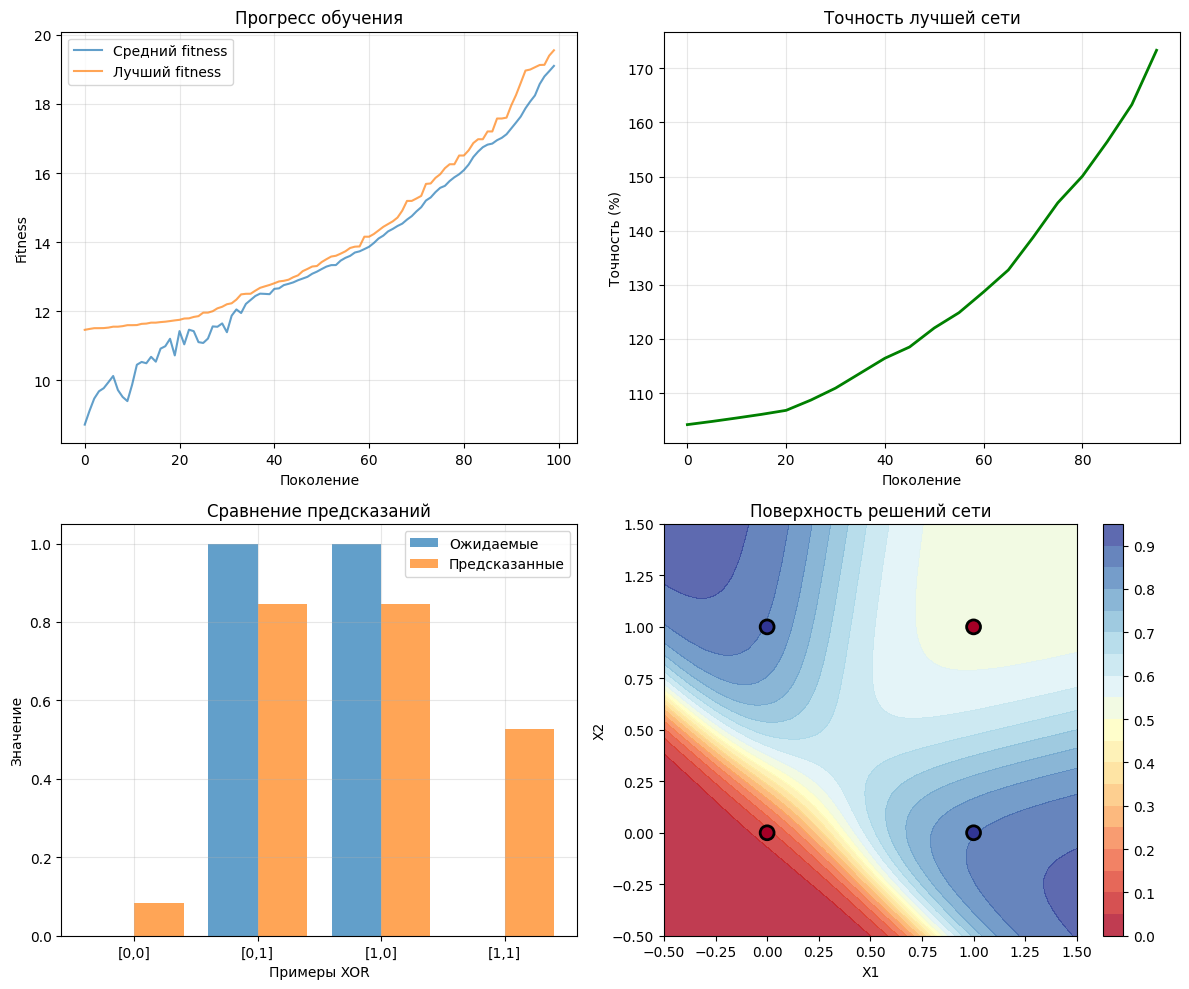

In [ ]:
# Визуализация прогресса обучения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. История fitness
ax1 = axes[0, 0]
ax1.plot(ga.fitness_history, label='Средний fitness', alpha=0.7)
ax1.plot(ga.best_fitness_history, label='Лучший fitness', alpha=0.7)
ax1.set_xlabel('Поколение')
ax1.set_ylabel('Fitness')
ax1.set_title('Прогресс обучения')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Точность предсказаний
ax2 = axes[0, 1]
test_points = []
accuracy_history = []

# Проверяем точность каждые 10 поколений (для демонстрации)
for i in range(0, len(ga.best_fitness_history), 5):
    if i < len(ga.best_fitness_history):
        # Здесь в реальном коде нужно сохранять лучшие сети каждого поколения
        test_points.append(i)
        accuracy_history.append(ga.best_fitness_history[i] / 11 * 100)  # Приблизительная точность

ax2.plot(test_points, accuracy_history, 'g-', linewidth=2)
ax2.set_xlabel('Поколение')
ax2.set_ylabel('Точность (%)')
ax2.set_title('Точность лучшей сети')
ax2.grid(True, alpha=0.3)

# 3. Предсказания сети
ax3 = axes[1, 0]
predictions = []
for i in range(len(X)):
    pred, _ = best_network.forward(X[i:i+1])
    predictions.append(pred[0][0])

x_pos = np.arange(len(X))
ax3.bar(x_pos - 0.2, y.flatten(), width=0.4, label='Ожидаемые', alpha=0.7)
ax3.bar(x_pos + 0.2, predictions, width=0.4, label='Предсказанные', alpha=0.7)
ax3.set_xlabel('Примеры XOR')
ax3.set_ylabel('Значение')
ax3.set_title('Сравнение предсказаний')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['[0,0]', '[0,1]', '[1,0]', '[1,1]'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Поверхность решений
ax4 = axes[1, 1]
# Создаем сетку точек
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 50),
                     np.linspace(-0.5, 1.5, 50))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Получаем предсказания для всех точек сетки
grid_predictions = []
for point in grid_points:
    pred, _ = best_network.forward(point.reshape(1, -1))
    grid_predictions.append(pred[0][0])
grid_predictions = np.array(grid_predictions).reshape(xx.shape)

# Визуализируем поверхность решений
contour = ax4.contourf(xx, yy, grid_predictions, levels=20, cmap='RdYlBu', alpha=0.8)
ax4.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=100,
           edgecolors='black', cmap='RdYlBu', linewidth=2)
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_title('Поверхность решений сети')
plt.colorbar(contour, ax=ax4)

plt.tight_layout()
plt.show()

In [ ]:
# Дополнительные тренировочные данные для лучшей обобщающей способности
X_train = np.array([
    [0, 0], [0, 1], [1, 0], [1, 1],
    [0.2, 0.8], [0.8, 0.2], [0.3, 0.3], [0.7, 0.7]
])
y_train = np.array([
    [0], [1], [1], [0],
    [1], [1], [0], [0]
])

In [ ]:
class ImprovedNeuralNetwork:
    def __init__(self, layer_sizes: List[int], weights: Optional[np.ndarray] = None):
        """
        Улучшенная нейронная сеть с дополнительными функциями
        """
        self.layer_sizes = layer_sizes

        if weights is None:
            self.weights = []
            for i in range(len(layer_sizes) - 1):
                # Улучшенная инициализация
                limit = np.sqrt(2.0 / (layer_sizes[i] + layer_sizes[i+1]))
                w = np.random.uniform(-limit, limit,
                                     (layer_sizes[i], layer_sizes[i+1]))
                self.weights.append(w)
        else:
            self.weights = self.decode_weights(weights)

    def activation(self, x: np.ndarray) -> np.ndarray:
        """Функция активации (tanh для лучших градиентов)"""
        return np.tanh(x)

    def activation_derivative(self, x: np.ndarray) -> np.ndarray:
        """Производная функции активации"""
        return 1 - x ** 2

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        """Прямой проход через сеть"""
        activations = [inputs]

        for i, w in enumerate(self.weights):
            z = np.dot(activations[-1], w)
            # Нормализация для стабильности
            z = np.clip(z, -100, 100)
            a = self.activation(z)
            activations.append(a)

        return activations[-1], activations

    def predict(self, inputs: np.ndarray) -> np.ndarray:
        """Предсказание сети"""
        output, _ = self.forward(inputs)
        # Порог 0.5 для tanh (выход в диапазоне [-1, 1])
        return (output > 0).astype(float)

    def get_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Вычисление точности"""
        predictions = self.predict(X)
        correct = np.sum(predictions == y)
        return correct / len(y) * 100

    def encode_weights(self) -> np.ndarray:
        """Кодирование весов в плоский массив"""
        return np.concatenate([w.flatten() for w in self.weights])

    def decode_weights(self, flat_weights: np.ndarray) -> List[np.ndarray]:
        """Декодирование плоского массива обратно в веса"""
        weights = []
        idx = 0

        for i in range(len(self.layer_sizes) - 1):
            size = self.layer_sizes[i] * self.layer_sizes[i + 1]
            w = flat_weights[idx:idx + size].reshape(
                self.layer_sizes[i], self.layer_sizes[i + 1])
            weights.append(w)
            idx += size

        return weights

    def get_fitness(self, X: np.ndarray, y: np.ndarray) -> float:
        """Вычисление приспособленности с улучшенной функцией"""
        predictions, _ = self.forward(X)

        # 1. MSE ошибка
        mse = np.mean((predictions - y) ** 2)

        # 2. Accuracy компонент
        binary_predictions = self.predict(X)
        accuracy = np.mean(binary_predictions == y)

        # 3. Штраф за неопределенность (предсказания близкие к 0.5)
        uncertainty_penalty = np.mean((predictions - 0.5) ** 2)

        # 4. Штраф за слишком большие веса (регуляризация)
        weight_penalty = 0.0
        for w in self.weights:
            weight_penalty += np.mean(w ** 2)
        weight_penalty *= 0.001

        # Комбинированная fitness функция
        fitness = (1.0 / (mse + 0.0001) +          # Чем меньше MSE, тем лучше
                   accuracy * 20 +                 # Награда за точность
                   uncertainty_penalty * 10 -      # Награда за уверенность
                   weight_penalty)                 # Штраф за большие веса

        # Дополнительный бонус за 100% точность
        if accuracy == 1.0:
            fitness += 50

        return max(fitness, 0.001)  # Гарантируем положительное значение

In [ ]:
class ImprovedGeneticAlgorithm:
    def __init__(self,
                 population_size: int,
                 layer_sizes: List[int],
                 mutation_rate: float = 0.2,
                 crossover_rate: float = 0.9,
                 elitism_count: int = 3,
                 adaptive_mutation: bool = True):
        """
        Улучшенный генетический алгоритм
        """
        self.population_size = population_size
        self.layer_sizes = layer_sizes
        self.base_mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_count = elitism_count
        self.adaptive_mutation = adaptive_mutation

        # Для адаптивной мутации
        self.fitness_history = deque(maxlen=10)

        # Создание начальной популяции
        self.population = self.create_initial_population()
        self.fitness_history_full = []
        self.best_fitness_history = []
        self.diversity_history = []

    def create_initial_population(self) -> List[ImprovedNeuralNetwork]:
        """Создание начальной популяции с разнообразием"""
        population = []

        # Вычисляем общее количество весов
        total_weights = 0
        for i in range(len(self.layer_sizes) - 1):
            total_weights += self.layer_sizes[i] * self.layer_sizes[i + 1]

        for i in range(self.population_size):
            # Разные стратегии инициализации для разнообразия
            if i % 4 == 0:
                # Нормальное распределение
                random_weights = np.random.normal(0, 1, total_weights)
            elif i % 4 == 1:
                # Равномерное распределение
                random_weights = np.random.uniform(-2, 2, total_weights)
            elif i % 4 == 2:
                # Маленькие значения
                random_weights = np.random.uniform(-0.5, 0.5, total_weights)
            else:
                # Большие значения
                random_weights = np.random.uniform(-3, 3, total_weights)

            nn = ImprovedNeuralNetwork(self.layer_sizes, random_weights)
            population.append(nn)

        return population

    def calculate_population_diversity(self) -> float:
        """Вычисление разнообразия популяции"""
        if len(self.population) <= 1:
            return 0.0

        # Берем кодировки всех особей
        encodings = [nn.encode_weights() for nn in self.population]

        # Вычисляем среднее попарное расстояние
        total_distance = 0
        count = 0

        for i in range(len(encodings)):
            for j in range(i + 1, len(encodings)):
                distance = np.linalg.norm(encodings[i] - encodings[j])
                total_distance += distance
                count += 1

        return total_distance / count if count > 0 else 0.0

    def evaluate_population(self, X: np.ndarray, y: np.ndarray) -> List[float]:
        """Оценка приспособленности всей популяции"""
        fitness_scores = []
        for nn in self.population:
            fitness = nn.get_fitness(X, y)
            fitness_scores.append(fitness)

        return fitness_scores

    def select_parents(self, fitness_scores: List[float]) -> List[ImprovedNeuralNetwork]:
        """Улучшенный отбор родителей"""
        parents = []

        # Нормализуем fitness scores для вероятностного отбора
        min_fitness = min(fitness_scores)
        max_fitness = max(fitness_scores)

        if max_fitness - min_fitness < 0.0001:
            # Если все fitness почти одинаковые, используем случайный отбор
            probabilities = np.ones(len(fitness_scores)) / len(fitness_scores)
        else:
            # Преобразуем fitness в вероятности (рулеточный отбор)
            normalized = (np.array(fitness_scores) - min_fitness) / (max_fitness - min_fitness + 1e-10)
            probabilities = normalized / np.sum(normalized)

        # Отбираем родителей
        for _ in range(self.population_size):
            # Используем вероятностный отбор
            idx = np.random.choice(len(self.population), p=probabilities)
            parents.append(self.population[idx])

        return parents

    def crossover(self, parent1: ImprovedNeuralNetwork, parent2: ImprovedNeuralNetwork) -> ImprovedNeuralNetwork:
        """Улучшенное скрещивание с несколькими стратегиями"""
        weights1 = parent1.encode_weights()
        weights2 = parent2.encode_weights()

        if np.random.random() < self.crossover_rate:
            # Случайный выбор стратегии кроссовера
            strategy = np.random.choice(['single_point', 'uniform', 'blend'])

            if strategy == 'single_point':
                # Одноточечное скрещивание
                crossover_point = np.random.randint(1, len(weights1) - 1)
                child_weights = np.concatenate([
                    weights1[:crossover_point],
                    weights2[crossover_point:]
                ])

            elif strategy == 'uniform':
                # Равномерное скрещивание
                mask = np.random.rand(len(weights1)) < 0.5
                child_weights = np.where(mask, weights1, weights2)

            else:  # blend
                # Смешивание (арифметический кроссовер)
                alpha = np.random.random()
                child_weights = alpha * weights1 + (1 - alpha) * weights2
        else:
            # Без кроссовера
            child_weights = weights1.copy()

        # Создаем новую нейронную сеть
        child_nn = ImprovedNeuralNetwork(self.layer_sizes, child_weights)
        return child_nn

    def mutate(self, nn: ImprovedNeuralNetwork, generation: int, max_generations: int) -> ImprovedNeuralNetwork:
        """Адаптивная мутация"""
        weights = nn.encode_weights()

        # Адаптивная скорость мутации
        if self.adaptive_mutation:
            # Уменьшаем мутацию со временем
            progress = generation / max_generations
            current_mutation_rate = self.base_mutation_rate * (1 - progress * 0.5)
        else:
            current_mutation_rate = self.base_mutation_rate

        for i in range(len(weights)):
            if np.random.random() < current_mutation_rate:
                # Разные типы мутаций
                mutation_type = np.random.choice(['gaussian', 'random', 'swap'])

                if mutation_type == 'gaussian':
                    # Гауссовская мутация с уменьшающейся дисперсией
                    sigma = 0.3 * (1 - generation / max_generations)
                    weights[i] += np.random.normal(0, sigma)

                elif mutation_type == 'random':
                    # Полностью случайное значение
                    weights[i] = np.random.uniform(-2, 2)

                else:  # swap
                    # Обмен с другим весом
                    if len(weights) > 1:
                        j = np.random.randint(0, len(weights))
                        weights[i], weights[j] = weights[j], weights[i]

                # Ограничиваем значения весов
                weights[i] = np.clip(weights[i], -5, 5)

        # Создаем новую нейронную сеть
        mutated_nn = ImprovedNeuralNetwork(self.layer_sizes, weights)
        return mutated_nn

    def create_new_generation(self, fitness_scores: List[float],
                            generation: int, max_generations: int) -> List[ImprovedNeuralNetwork]:
        """Создание нового поколения"""
        new_population = []

        # Элитизм: сохраняем лучших особей
        elite_indices = np.argsort(fitness_scores)[-self.elitism_count:]
        for idx in elite_indices:
            new_population.append(self.population[idx])

        # Отбор родителей
        parents = self.select_parents(fitness_scores)

        # Время от времени добавляем случайные особи для разнообразия
        if generation % 20 == 0 and generation < max_generations * 0.8:
            total_weights = sum(self.layer_sizes[i] * self.layer_sizes[i + 1]
                              for i in range(len(self.layer_sizes) - 1))
            random_weights = np.random.uniform(-1, 1, total_weights)
            random_nn = ImprovedNeuralNetwork(self.layer_sizes, random_weights)
            new_population.append(random_nn)

        # Создание потомков
        while len(new_population) < self.population_size:
            # Выбираем двух родителей
            parent1, parent2 = np.random.choice(parents, 2, replace=False)

            # Скрещивание
            child = self.crossover(parent1, parent2)

            # Мутация
            child = self.mutate(child, generation, max_generations)

            new_population.append(child)

        return new_population[:self.population_size]

    def evolve(self,
               X: np.ndarray,
               y: np.ndarray,
               generations: int = 200,
               patience: int = 30) -> ImprovedNeuralNetwork:
        """
        Основной цикл эволюции с ранней остановкой
        """
        print("="*60)
        print("Начало эволюции (улучшенный алгоритм)")
        print("="*60)

        best_network = None
        best_fitness = -np.inf
        best_accuracy = 0
        no_improvement_count = 0

        for generation in range(generations):
            # Оценка текущей популяции
            fitness_scores = self.evaluate_population(X, y)

            # Сохранение истории
            avg_fitness = np.mean(fitness_scores)
            max_fitness = np.max(fitness_scores)
            self.fitness_history_full.append(avg_fitness)
            self.best_fitness_history.append(max_fitness)

            # Вычисление разнообразия
            diversity = self.calculate_population_diversity()
            self.diversity_history.append(diversity)

            # Обновление лучшей сети
            current_best_idx = np.argmax(fitness_scores)
            current_best_nn = self.population[current_best_idx]
            current_accuracy = current_best_nn.get_accuracy(X, y)

            if max_fitness > best_fitness or (max_fitness == best_fitness and current_accuracy > best_accuracy):
                best_fitness = max_fitness
                best_accuracy = current_accuracy
                best_network = current_best_nn
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # Создание нового поколения
            self.population = self.create_new_generation(
                fitness_scores, generation, generations)

            # Вывод информации
            if generation % 10 == 0 or generation == generations - 1:
                print(f"Поколение {generation:3d}: "
                      f"Лучшая fitness = {best_fitness:.4f}, "
                      f"Точность = {best_accuracy:.2f}%, "
                      f"Разнообразие = {diversity:.4f}")

            # Ранняя остановка
            if no_improvement_count >= patience and best_accuracy == 100:
                print(f"\nРанняя остановка на поколении {generation}: достигнута 100% точность!")
                break

        return best_network

In [ ]:
from collections import deque

In [ ]:
# Параметры улучшенного алгоритма
POPULATION_SIZE = 100
GENERATIONS = 200
LAYER_SIZES = [2, 6, 4, 1]  # Больше скрытых слоев для XOR

# Создание и запуск улучшенного генетического алгоритма
improved_ga = ImprovedGeneticAlgorithm(
    population_size=POPULATION_SIZE,
    layer_sizes=LAYER_SIZES,
    mutation_rate=0.25,
    crossover_rate=0.9,
    elitism_count=4,
    adaptive_mutation=True
)

# Запуск эволюции
best_improved_network = improved_ga.evolve(X_train, y_train, GENERATIONS, patience=20)

# Тестирование лучшей сети
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ (улучшенный алгоритм)")
print("="*60)

print("\nТестирование на XOR данных:")
for i in range(len(X)):
    prediction, _ = best_improved_network.forward(X[i:i+1])
    binary_pred = best_improved_network.predict(X[i:i+1])[0][0]
    print(f"Вход: {X[i]}, Ожидаемый: {y[i][0]}, "
          f"Предсказанный: {prediction[0][0]:.6f}, "
          f"Бинарный: {binary_pred}")

accuracy = best_improved_network.get_accuracy(X, y)
print(f"\nТочность на XOR данных: {accuracy:.2f}%")

# Тестирование на дополнительных данных
print("\nТестирование на дополнительных данных:")
for i in range(4, len(X_train)):
    prediction, _ = best_improved_network.forward(X_train[i:i+1])
    binary_pred = best_improved_network.predict(X_train[i:i+1])[0][0]
    print(f"Вход: {X_train[i]}, Ожидаемый: {y_train[i][0]}, "
          f"Предсказанный: {prediction[0][0]:.6f}, "
          f"Бинарный: {binary_pred}")

total_accuracy = best_improved_network.get_accuracy(X_train, y_train)
print(f"\nОбщая точность: {total_accuracy:.2f}%")

Начало эволюции (улучшенный алгоритм)
Поколение   0: Лучшая fitness = 30.5157, Точность = 75.00%, Разнообразие = 9.8707
Поколение  10: Лучшая fitness = 79.6281, Точность = 100.00%, Разнообразие = 9.5730
Поколение  20: Лучшая fitness = 79.6281, Точность = 100.00%, Разнообразие = 9.6546

Ранняя остановка на поколении 24: достигнута 100% точность!

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ (улучшенный алгоритм)

Тестирование на XOR данных:
Вход: [0 0], Ожидаемый: 0, Предсказанный: 0.000000, Бинарный: 0.0
Вход: [0 1], Ожидаемый: 1, Предсказанный: 0.960550, Бинарный: 1.0
Вход: [1 0], Ожидаемый: 1, Предсказанный: 0.488449, Бинарный: 1.0
Вход: [1 1], Ожидаемый: 0, Предсказанный: -0.191815, Бинарный: 0.0

Точность на XOR данных: 100.00%

Тестирование на дополнительных данных:
Вход: [0.2 0.8], Ожидаемый: 1, Предсказанный: 0.964932, Бинарный: 1.0
Вход: [0.8 0.2], Ожидаемый: 1, Предсказанный: 0.104415, Бинарный: 1.0
Вход: [0.3 0.3], Ожидаемый: 0, Предсказанный: -0.133363, Бинарный: 0.0
Вход: [0.7 0.7], Ожидаемый: 0, П

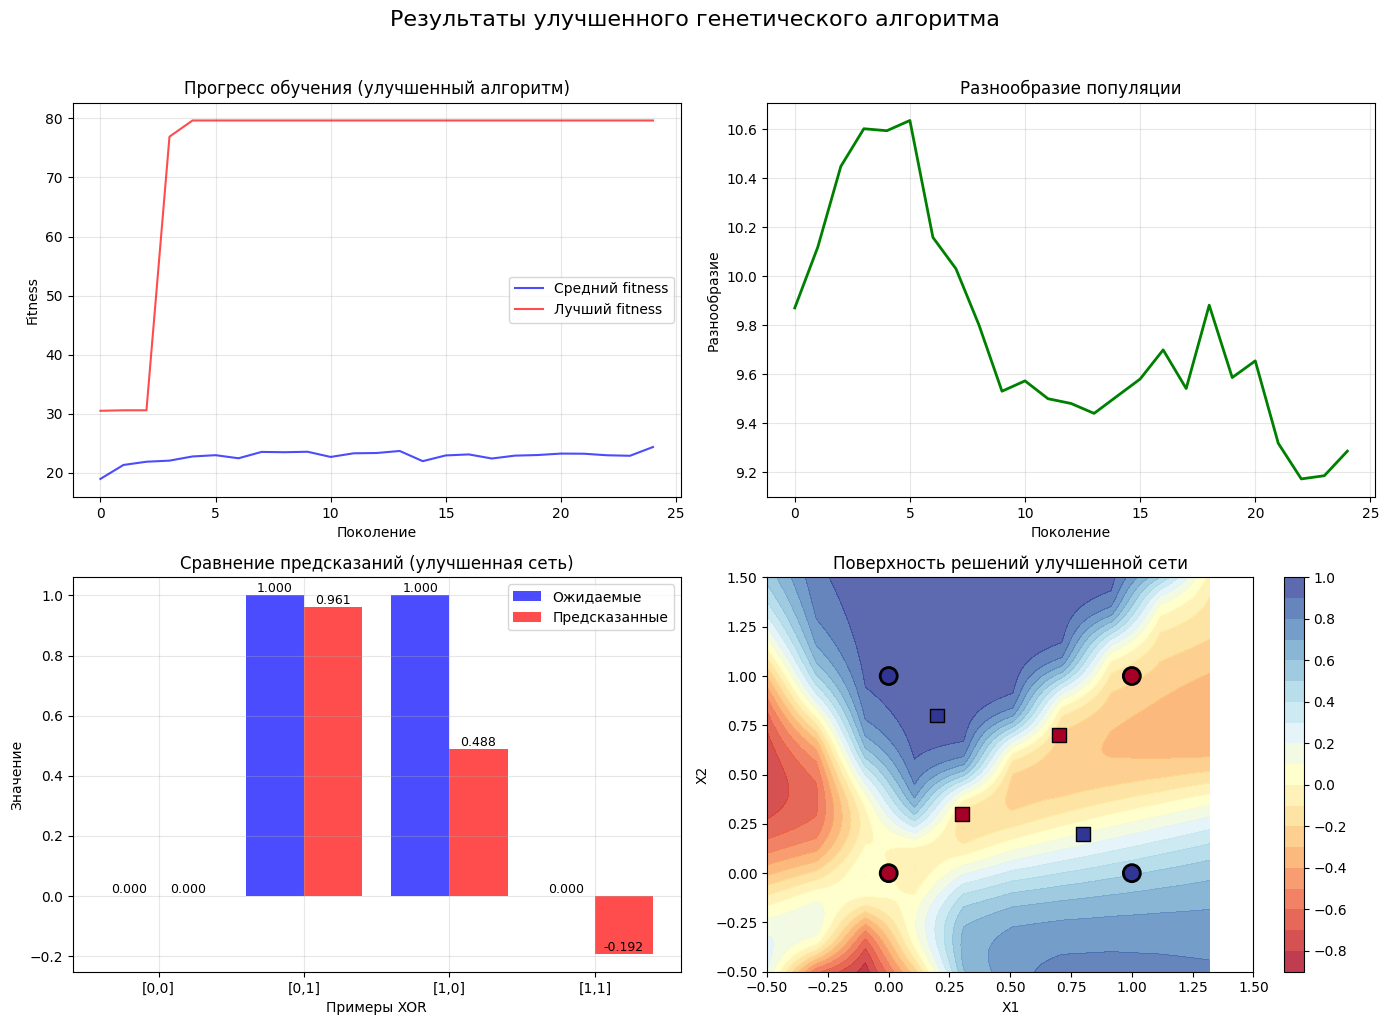


АНАЛИЗ ВЕСОВ ЛУЧШЕЙ СЕТИ

Слой 0 -> 1:
  Размер: (2, 6)
  Среднее значение: -0.020283
  Стандартное отклонение: 1.501894
  Минимальное значение: -2.338427
  Максимальное значение: 2.623977

Слой 1 -> 2:
  Размер: (6, 4)
  Среднее значение: 0.123128
  Стандартное отклонение: 1.192036
  Минимальное значение: -2.940453
  Максимальное значение: 2.221372

Слой 2 -> 3:
  Размер: (4, 1)
  Среднее значение: 0.018082
  Стандартное отклонение: 1.521098
  Минимальное значение: -1.147179
  Максимальное значение: 2.594705

ТЕСТИРОВАНИЕ НА СЛУЧАЙНЫХ ДАННЫХ
[1, 0] -> XOR: 1, Предсказание: 1.0 ✓
[1, 1] -> XOR: 0, Предсказание: 0.0 ✓
[0, 1] -> XOR: 1, Предсказание: 1.0 ✓
[0, 0] -> XOR: 0, Предсказание: 0.0 ✓
[1, 0] -> XOR: 1, Предсказание: 1.0 ✓
[0, 0] -> XOR: 0, Предсказание: 0.0 ✓
[0, 1] -> XOR: 1, Предсказание: 1.0 ✓
[0, 1] -> XOR: 1, Предсказание: 1.0 ✓
[0, 0] -> XOR: 0, Предсказание: 0.0 ✓
[1, 0] -> XOR: 1, Предсказание: 1.0 ✓
[1, 1] -> XOR: 0, Предсказание: 0.0 ✓
[0, 0] -> XOR: 0, Предсказание: 

In [ ]:
# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. История fitness
ax1 = axes[0, 0]
ax1.plot(improved_ga.fitness_history_full, 'b-', label='Средний fitness', alpha=0.7)
ax1.plot(improved_ga.best_fitness_history, 'r-', label='Лучший fitness', alpha=0.7)
ax1.set_xlabel('Поколение')
ax1.set_ylabel('Fitness')
ax1.set_title('Прогресс обучения (улучшенный алгоритм)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Разнообразие популяции
ax2 = axes[0, 1]
ax2.plot(improved_ga.diversity_history, 'g-', linewidth=2)
ax2.set_xlabel('Поколение')
ax2.set_ylabel('Разнообразие')
ax2.set_title('Разнообразие популяции')
ax2.grid(True, alpha=0.3)

# 3. Предсказания сети
ax3 = axes[1, 0]
predictions = []
for i in range(len(X)):
    pred, _ = best_improved_network.forward(X[i:i+1])
    predictions.append(pred[0][0])

x_pos = np.arange(len(X))
bars1 = ax3.bar(x_pos - 0.2, y.flatten(), width=0.4, label='Ожидаемые', alpha=0.7, color='blue')
bars2 = ax3.bar(x_pos + 0.2, predictions, width=0.4, label='Предсказанные', alpha=0.7, color='red')

# Добавляем значения на столбцы
for bar in bars1 + bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax3.set_xlabel('Примеры XOR')
ax3.set_ylabel('Значение')
ax3.set_title('Сравнение предсказаний (улучшенная сеть)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['[0,0]', '[0,1]', '[1,0]', '[1,1]'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Поверхность решений
ax4 = axes[1, 1]
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100),
                     np.linspace(-0.5, 1.5, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Получаем предсказания для всех точек сетки
grid_predictions = []
for i in range(0, len(grid_points), 10):  # Для скорости берем каждый 10-й
    pred, _ = best_improved_network.forward(grid_points[i:i+1])
    grid_predictions.append(pred[0][0])

# Дополняем оставшиеся
for i in range(len(grid_predictions) * 10, len(grid_points), 10):
    pred, _ = best_improved_network.forward(grid_points[i:i+1])
    grid_predictions.append(pred[0][0])

# Интерполяция для визуализации
from scipy.interpolate import griddata
grid_predictions_full = np.zeros(len(grid_points))
grid_predictions_full[::10] = grid_predictions
grid_predictions_full = griddata(grid_points[::10], grid_predictions,
                                grid_points, method='linear')
grid_predictions_full = grid_predictions_full.reshape(xx.shape)

# Визуализируем поверхность решений
contour = ax4.contourf(xx, yy, grid_predictions_full, levels=20,
                      cmap='RdYlBu', alpha=0.8)
ax4.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=150,
           edgecolors='black', cmap='RdYlBu', linewidth=2)
ax4.scatter(X_train[4:, 0], X_train[4:, 1], c=y_train[4:].flatten(),
           s=100, marker='s', edgecolors='black', cmap='RdYlBu', linewidth=1)
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.set_title('Поверхность решений улучшенной сети')
plt.colorbar(contour, ax=ax4)

plt.suptitle('Результаты улучшенного генетического алгоритма', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Анализ весов лучшей сети
print("\n" + "="*60)
print("АНАЛИЗ ВЕСОВ ЛУЧШЕЙ СЕТИ")
print("="*60)

for i, w in enumerate(best_improved_network.weights):
    print(f"\nСлой {i} -> {i+1}:")
    print(f"  Размер: {w.shape}")
    print(f"  Среднее значение: {np.mean(w):.6f}")
    print(f"  Стандартное отклонение: {np.std(w):.6f}")
    print(f"  Минимальное значение: {np.min(w):.6f}")
    print(f"  Максимальное значение: {np.max(w):.6f}")

# Проверка на случайных данных
print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ НА СЛУЧАЙНЫХ ДАННЫХ")
print("="*60)

test_cases = 20
correct = 0

for _ in range(test_cases):
    x1, x2 = np.random.randint(0, 2, 2)
    expected = x1 ^ x2
    prediction = best_improved_network.predict(np.array([[x1, x2]]))[0][0]

    if prediction == expected:
        correct += 1
        symbol = "✓"
    else:
        symbol = "✗"

    print(f"[{x1}, {x2}] -> XOR: {expected}, Предсказание: {prediction} {symbol}")

